<div align="center"> 
<img src='./img/header.png' height='160px'/>
</div>

# Introduction

### [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

### Velocity granules
    
All image pairs are processed using the JPL autonomous Repeat Image Feature Tracking algorithms (auto-RIFT), first presented in (Gardner et al., 2018). Release v00.0 of the ITS_LIVE velocity mosaics use auto-RIFT Version 1. This ITS_LIVE data set uses surface displacements generated by image pairs  in repeat orbits, and image pairs generated by overlap areas of adjacent or near-adjacent orbits. Image pairs collected from the same satellite position ("same-path-row") are searched if they have a time separation of fewer than 546 days. This approach was used for all satellites in the Landsat series (L4 to L8). To increase data density prior to the launch of Landsat 8, images acquired from differing satellite positions, generally in adjacent or near-adjacent orbit swaths ("cross-path-row"), are also processed if they have a time separation between 10 and 96 days and an acquisition date prior to 14 June 2013(beginning of regular Landsat 8 data). Feature tracking of cross-path-row image pairs produces velocity fields with a lower signal-to-noise ratio due to residual parallax from imperfect terrain correction. Same-path-row and cross-path-row preprocessed pairs of images are searched for matching features by finding local normalized cross-correlation (NCC) maxima at sub-pixel resolution by oversampling the correlation surface by a factor of 16 using a Gaussian kernel. A sparse grid pixel-integer NCC search (1/16 of the density of full search grid) is used to determine areas of coherent correlation between image pairs. For more information, see the Normalized Displacement Coherence (NDC) filter described in Gardner et al. (2018)


### Coverage

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days

## Search API


### Spatial matching
<div align="left"> 
<img src='./img/itslive-selection.png' height='160px'/>
</div>

### Temporal matching

### Other parameters

### Map Widget

---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at nsidc@nsidc.org

In [1]:
from SearchWidget import map
# vertical means use Jupyter's sidecar panel, horizontal=render in notebook.
m = map(orientation='vertical')
m.display()

In [ ]:
# If you want to get the current selection parameters you can use the following method.
m.get_current_selection()

In [ ]:
# you can also define your own parameters and skip the widget.
params = {
    'bbox': '-49.79,69.06,-48.55,69.25',
    'start': '1993-01-01',
    'end': '2021-03-25',
    'percent_valid_pixels': 60,
    'min_separation': 6,
    'max_separation': 90
}

granule_urls = m.Search(params)
print(f'Total granules found: {len(granule_urls)}')

### Filtering

More than a thousand granules doesn't seem much but it's not trivial if you only want to get a glance of the behavior of a particular glacier over the years. For this reason we can cap the number of granules per year and accepts only those with a given month as a middate, this is useful if the glacier is affected by seasonal cycles.

In [ ]:
# filter_urls requires a list of urls, the result is stored in the m.filtered_urls attribute
filtered_granules_by_year = m.filter_urls(granule_urls,
                                          max_files_per_year=10,
                                          months=['April', 'June', 'August'],
                                          by_year=True)

# We print the counts per year
for k in filtered_granules_by_year:
    print(k, len(filtered_granules_by_year[k]))
print(f'Total granules after filtering: {len(m.filtered_urls)}')

In [ ]:
# This one only caps the number of granules per year
filtered_granules = m.filter_urls(granule_urls,
                                          max_files_per_year=100,
                                          by_year=False)

# We print the counts per year
print(f'Total granules after filtering: {len(filtered_granules)}')

### Downloading data

We have 2 options to download data, we can download filtered urls (by year or as a whole) or we can donload a whole set of URLs returned in our original search.

Single year example:

```python
files = m.download_velocity_granules(urls=filtered_granules_by_year['1993'],
                                     path_prefix='data/jakobshavn-1993',
                                     params=params)
```

The `path_prefix` is the dorectory on which the netcdf files will be downloaded to and `params` is to keep track of which parameters were used to download a particular set of files.

We can also download the whole series

```python
files = m.download_velocity_granules(urls=m.filtered_urls,
                                     path_prefix='data/jakobshavn-1993-2018',
                                     filtered_urls=params)

```

In [ ]:
filtered_urls = m.filtered_urls # or filtered_granules if we are not using the widget
project_folder = 'data/pine-1998-2018'

# if we are using our parameters (not the widget) we asign our own dict i.e. params=my_params
files = m.download_velocity_granules(urls=filtered_urls,
                                     path_prefix=project_folder,
                                     params=m.get_current_selection())

## Dataset structure

A velocity granule granule comes in NetCDF format and contains variables derived from 2 satellite taken scenes, optical or radar. 

## Processing

The most common use case for the velocity granules is to generate a time series. In order to create it we need to concatenate multiple granules from the region of interest for the time we want information from. 

To achieve this, ITS_LIVE provides a processing module that will load all the velocity granules on a given directory and use a user defined geojson geometry to
clip the files so just the data inside the geometry will be used to create the cube.

> **IMPORTANT:** `load_cube` is not a lazy function. It will allocate granaules on memory in order to create the cube. This means that if we try to load 100,000 granules the kernel will most likely run out of memory. 
* Note: If we don't use the map widget we can also use a handy function to get the geojson polygon from a bounding box.

The signature of the `load_cube` method is `load_cube(project_folder, clip_geom=geometry, discard_residual_projections=False)`

The parameters are:
* **project_folder**: The file path pattern for NetCDF velocity files
* **clip_geom**: gejson geometry dictionary, this geometry will be used to [clip the files](https://corteva.github.io/rioxarray/html/examples/clip_geom.html)
* **discard_residual_projections**: True or False, if True the cube will discard granules on different UTM zones than the most common one for the selected area.


In [2]:
from VelocityProcessing import VelocityProcessing as vp

# GeoJSON geometry
# geometry = vp.box_to_geojson([-49.79, 69.06, -48.55, 69.25])
# geometry = vp.polygon_to_geojson([(-48.55, 69.06),(-48.55, 69.25),(-49.79, 69.25),(-49.79, 69.06),(-48.55, 69.06)])
# if we use the widget
geometry = m.get_current_selection()['geometry'] 
geometry

{'type': 'Polygon',
 'coordinates': [[[-75.799563, -73.362843],
   [-75.309978, -73.680038],
   [-77.262045, -73.860843],
   [-76.836768, -73.311726],
   [-76.049459, -73.304661],
   [-75.799563, -73.362843]]]}

In [3]:
%%time
project_folder = 'data/glacier/*.nc'

cube = vp.load_cube(project_folder,
                    clip_geom=geometry,
                    discard_residual_projections=True)
cube

CPU times: user 27.2 s, sys: 695 ms, total: 27.9 s
Wall time: 28.1 s


<xarray.Dataset>
Dimensions:              (time: 45, x: 235, y: 265)
Coordinates:
  * x                    (x) float64 -1.778e+06 -1.777e+06 ... -1.721e+06
  * y                    (y) float64 3.892e+05 3.894e+05 ... 4.523e+05 4.525e+05
  * time                 (time) datetime64[ns] 2013-11-22 ... 2019-02-19
    Polar_Stereographic  int64 0
Data variables:
    vx                   (time, y, x) float32 nan nan nan nan ... nan nan nan
    vy                   (time, y, x) float32 nan nan nan nan ... nan nan nan
    v                    (time, y, x) float32 nan nan nan nan ... nan nan nan
    chip_size_width      (time, y, x) float32 nan nan nan nan ... nan nan nan
    chip_size_height     (time, y, x) float32 nan nan nan nan ... nan nan nan
    interp_mask          (time, y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    GDAL_AREA_OR_POINT:       Area
    Conventions:              CF-1.6
    date_created:             30-Mar-2020 20:58:13
    title:                    autoRIFT surface velocities
    author:                   Alex S. Gardner, JPL/NASA
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    scene_pair_type:          optical
    motion_detection_method:  feature
    motion_coordinates:       map
    grid_mapping:             Polar_Stereographic

In [ ]:
cube.isel().v.plot.imshow(x='x',y='y')

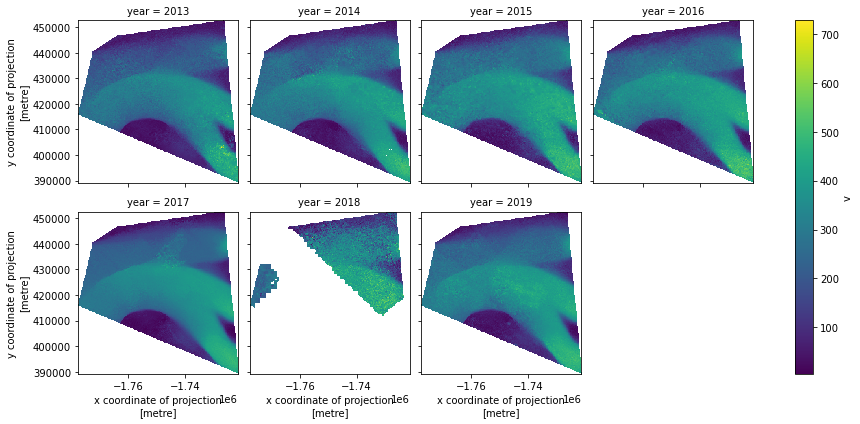

In [43]:
# We can now use xarray fancy operations to calculate means/max etc and plot over time.
cube_yearly = cube.groupby('time.year').mean()
cube_yearly.v.plot.imshow(x='x',y='y',col='year', col_wrap=4)

(array([1.65432e+05, 2.03383e+05, 3.16467e+05, 1.76547e+05, 1.16800e+04,
        6.74000e+02, 1.16000e+02, 3.20000e+01, 1.40000e+01, 2.00000e+00]),
 array([   0. ,  121.6,  243.2,  364.8,  486.4,  608. ,  729.6,  851.2,
         972.8, 1094.4, 1216. ], dtype=float32),
 <BarContainer object of 10 artists>)

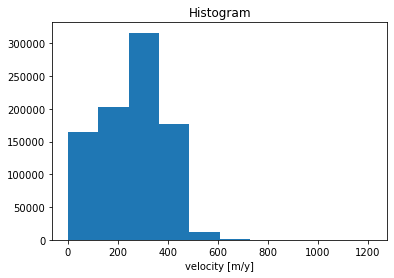

In [6]:
# Histogram of velocities to potentially discard outliers.
cube.v.plot.hist()

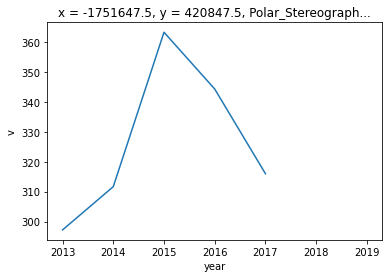

In [39]:

centroid_x = round(len(cube.v.x)/2)
centroid_y = round(len(cube.v.y)/2)


cube.v.sel(x=cube.v.x[centroid_x-10], y=cube.v.y[centroid_y]).groupby('time.year').mean().plot()